In [64]:
import matplotlib.pyplot as plt
import numpy as np

In [85]:
class MultiClassNetwork:
    def __init__(self, units=10,batch_size=32, learning_rate=0.1, l1=0, l2=0):       
        self.units=units # 은닉층의 뉴런 개수
        self.batch_size=batch_size
        self.w1=None #은닉층의 가중치
        self.b1=None #은닉층의 절편
        self.w2=None #출력층의 가중치
        self.b2=None #출력층의 절편
        self.a1=None #은닉층의 활성화 출력 -> 역방향을 계산할 때 필요하다
        self.losses=[] 
        self.val_losses=[]
        self.lr=learning_rate
        self.l1=l1
        self.l2=l2
    def forpass(self,x): 
        z1=np.dot(x,self.w1)+self.b1 #첫번째 층의 선형식
        self.a1=self.sigmoid(z1)
        z2=np.dot(self.a1,self.w2)+self.b2 #두번째 층의 선형식
        return z2
    def backprop(self,x,err):
        m=len(x)
        #출력층의 가중치와 절편에 대한 그레이디언트 계산
        w2_grad=np.dot(self.a1.T,err)/m 
        b2_grad=np.sum(err)/m 
        #시그모이드 함수까지의 그레이드언트를 계산
        err_to_hidden=np.dot(err,self.w2.T)*self.a1*(1-self.a1)
        #은닉층의 가중치와 절편에 대한 그레이디언트 계산
        w1_grad=np.dot(x.T,err_to_hidden)/m 
        b1_grad=np.sum(err_to_hidden,axis=0)/m 
        return w1_grad, b1_grad ,w2_grad, b2_grad
    def sigmoid(self,z):
        a=1/(1+np.exp(-z))
        return a
    def softmax(self, z):
        exp_z=np.exp(z)
        return (exp_z)/np.sum(exp_z, axis=1).reshape(-1,1)
    def init_weights(self,n_features,n_classes):
        self.w1=np.random.normal(0,1,(n_features,self.units)) #특성개수, 은닉층의 크기
        self.b1=np.zeros(self.units) #은닉층의 크기
        self.w2=np.random.normal(0,1,(self.units, n_classes)) #은닉층의 크기, 1
        self.b2=np.zeros(n_classes)
    def fit(self,x,y,epochs=100,x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])
        for i in range (epochs):
            loss=0
            print('.',end='')
            for x_batch, y_batch in self.gen_batch(x,y):
                a=self.training(x_batch,y_batch)
                a=np.clip(a, 1e-10, 1-1e-10) #안전한 로그 계산을 위해서 클리핑 후
                loss+=np.sum(-(y_batch*np.log(a))) # 손실 누적
            self.losses.append((loss+self.reg_loss())/len(x)) #각 에포크마다 평균 손실 계산하여 저장
            self.update_val_loss(x_val,y_val)#검증세트에 대한 손실을 계산
    def gen_batch(self,x,y):
        length=len(x)
        bins=length//self.batch_size
        if length % self.batch_size:
            bins+=1
        indexes=np.random.permutation(np.arange(len(x)))
        x=x[indexes]
        y=y[indexes]
        for i in range(bins):
            start=self.batch_size*i
            end=self.batch_size*(i+1)
            yield x[start:end], y[start:end]
    def training(self,x,y):
        m=len(x)
        z=self.forpass(x) #정방형 계산
        a=self.softmax(z) #활성화 함수 적용
        err=-(y-a) # 오차계산 
        w1_grad, b1_grad, w2_grad, b2_grad=self.backprop(x,err) #역방형 계산
        w1_grad+=(self.l1*np.sign(self.w1)+self.l2*self.w1)/m
        w2_grad+=(self.l1*np.sign(self.w2)+self.l2*self.w2)/m
        self.w1-=self.lr*w1_grad #가중치 업데이트(학습률 적용)
        self.b1-=self.lr*b1_grad #절편 업데이트
        self.w2-=self.lr*w2_grad #가중치 업데이트(학습률 적용)
        self.b2-=self.lr*b2_grad #절편 업데이트
        return a
    def update_val_loss(self,x_val, y_val):
        z=self.forpass(x_val) #정방형 계산
        a=self.softmax(z)
        a=np.clip(a, 1e-10, 1-1e-10)
        val_loss=np.sum(-(y_val*np.log(a)))
        self.val_losses.append((val_loss+self.reg_loss())/len(y_val))
    def reg_loss(self):
        return self.l1*(np.sum(np.abs(self.w1))+np.sum(np.abs(self.w2)))+\
                self.l2/2*(np.sum(self.w1**2)+np.sum(self.w2**2))
    def predict(self, x):
        z=self.forpass(x)
        return np.argmax(z,axis=1)
    def score(self, x, y):
        return np.mean(self.predict(x)==np.argmax(y, axis=1))

In [86]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [87]:
(x_train_all, y_train_all),(x_test, y_test)=tf.keras.datasets.fashion_mnist.load_data()

In [88]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


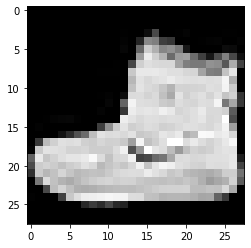

In [89]:
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [90]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [91]:
class_names=['티셔츠/윗도리','바지', '스웨터', '드레스', '코트',
            '샌들','셔츠', '스니커즈', '가방', '앵클부츠']
print(class_names[y_train_all[0]])

앵클부츠


In [92]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
      dtype=int64)

In [93]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val=train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [94]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800],
      dtype=int64)

In [95]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200],
      dtype=int64)

In [96]:
#정규화 작업
x_train=x_train/225 #이미지 데이터는 픽셀마다 0에서 225사이의 값을 가지기 때문에
x_val=x_val/225

In [97]:
x_train=x_train.reshape(-1, 784) #28*28(2차원 배열)=784(1차원 배열 , 각 샘플을 행벡터로 ) 
x_val=x_val.reshape(-1, 784)
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [98]:
# one- hot encoding
tf.keras.utils.to_categorical([0,1,3])#example

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [99]:
y_train_encoded=tf.keras.utils.to_categorical(y_train)
y_val_encoded=tf.keras.utils.to_categorical(y_val)

In [100]:
print(y_train_encoded.shape, y_val_encoded.shape) #2차원 배열로 바뀐 것 확인 가능

(48000, 10) (12000, 10)


In [101]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [102]:
fc=MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

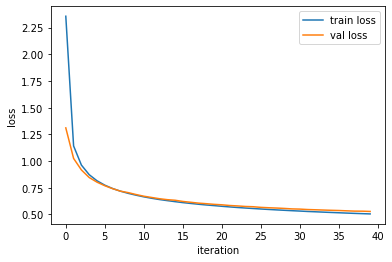

In [103]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

In [104]:
fc.score(x_val, y_val_encoded)

0.8111666666666667

In [105]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model=Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

In [106]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [107]:
history=model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 1s 846us/step - loss: 1.6805 - accuracy: 0.5380 - val_loss: 0.9146 - val_accuracy: 0.7367
Epoch 2/40
1500/1500 [==============================] - 1s 767us/step - loss: 0.8473 - accuracy: 0.7450 - val_loss: 0.7211 - val_accuracy: 0.7659
Epoch 3/40
1500/1500 [==============================] - 1s 763us/step - loss: 0.7075 - accuracy: 0.7681 - val_loss: 0.6399 - val_accuracy: 0.7893
Epoch 4/40
1500/1500 [==============================] - 1s 783us/step - loss: 0.6352 - accuracy: 0.7865 - val_loss: 0.5912 - val_accuracy: 0.7998
Epoch 5/40
1500/1500 [==============================] - 1s 773us/step - loss: 0.5990 - accuracy: 0.7966 - val_loss: 0.5582 - val_accuracy: 0.8098
Epoch 6/40
1500/1500 [==============================] - 1s 769us/step - loss: 0.5539 - accuracy: 0.8125 - val_loss: 0.5318 - val_accuracy: 0.8148
Epoch 7/40
1500/1500 [==============================] - 1s 777us/step - loss: 0.5397 - accuracy: 0.8148 - val_loss: 0.5142 -

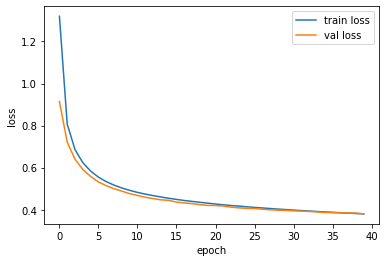

In [108]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

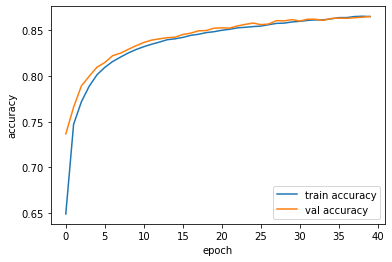

In [109]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

In [111]:
loss, accuracy=model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)
print(loss)

0.8653333187103271
0.3801240622997284
